# Aim

Get good and fast PSF fitting working, with the current models, in Python 3.8+. This could be using Theano, tf2+, or pytorch, and probably won't be using scipy.

1. (in the `oldeleanor` env) run code from master to show the baseline of fitting works
2. (in the `eleanorupgrade` env) set up frame-by-frame fitting in a new language, for sim data
3. the same as above for real data
4. set up all-at-once fitting using different weights for fluxes, and deviation-from-aperture regularization for coherence
5. the same as above for real data

In [2]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
%load_ext autoreload
%autoreload 2

In [3]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=13, 
    width=13, 
    do_pca=True, 
    do_psf=False
)

In [5]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, verbose=True, nstars=3, xc=[4.9, 4.5, 4.7], yc=[3.0, 4.4, 7.0], ignore_pixels=1)

TypeError: psf_lightcurve() got an unexpected keyword argument 'data_arrdata_arr'

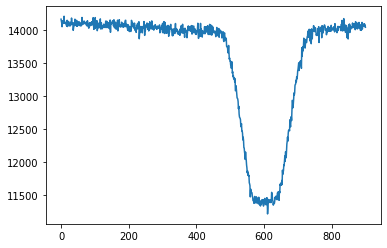

In [75]:
plt.plot(data.psf_flux[:,0])

In [76]:
data.psf_params

array([[ 0.71115441, -0.10902816,  0.80008996],
       [ 0.70858069, -0.10707549,  0.79902802],
       [ 0.69946772, -0.10540282,  0.79775301],
       ...,
       [ 0.71090511, -0.10661583,  0.79599263],
       [ 0.71020598, -0.10489393,  0.79378999],
       [ 0.70986235, -0.10812206,  0.79873936]])

In [4]:
import tensorflow as tf
import numpy as np
import scipy.optimize as sopt

def f_model(x):
    return tf.reduce_sum(tf.square(x-tf.constant(2, dtype=tf.float32)))

@tf.function
def val_and_grad(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = f_model(x)
    grad = tape.gradient(loss, x)
    return loss, grad

def func(x):
    res = [vv.numpy().astype(np.float64) for vv in val_and_grad(tf.constant(x, dtype=tf.float32))]
    return res

resdd = sopt.minimize(fun=func, x0=3*np.ones(5), jac=True, method='L-BFGS-B')

print("info:\n",resdd)

info:
       fun: 2.8421709430404007e-13
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.76837158e-07, 4.76837158e-07, 4.76837158e-07, 4.76837158e-07,
       4.76837158e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([2.00000012, 2.00000012, 2.00000012, 2.00000012, 2.00000012])


In [5]:
pars0

NameError: name 'pars0' is not defined

In [16]:
xc = [4.9, 4.5, 4.7] 
yc = [3.0, 4.4, 7.0]
model = eleanor.models.Gaussian(
    shape=tpfs.shape[1:],
    col_ref = 0,
    row_ref = 0,
    xc = xc,
    yc = yc,
    fit_idx = 0,
    bkg0 = np.max(bkgs[0])
)
nstars = len(xc)
fout = np.zeros((len(tpfs), 3))
lout = np.zeros(len(tpfs))
pars0 = model.get_default_par(tpfs[0])

tpfs = np.array(tpfs, dtype=np.float32)
errs = np.array(errs, dtype=np.float32)

import jax.numpy as jnp
from jax import grad # remember to install jaxlib

loss = lambda mean_val, i: jnp.sum((mean_val - tpfs[i]) ** 2 / errs[i])

def loss_fn(params, i):
    for j, p in enumerate(params):
        if not(model.bounds[j, 0] <= p and p <= model.bounds[j, 1]):
            return np.infty
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    return loss(mean_val, i)

loss_fn(pars0, 0)

DeviceArray(40513670., dtype=float32)

In [53]:
loss_fn(pars0 - 1e-10 * grad_fn(pars0, 0), 0)

DeviceArray(40455336., dtype=float32)

In [44]:
grad(loss_fn)(pars0, 3)

DeviceArray([-4.8649893e+02, -9.1114246e+02, -5.0716370e+02,
              2.2673736e+07,  7.3639720e+06, -9.1125898e+03,
             -2.7456202e+06,  1.8855470e+06,  1.3953994e+05],            dtype=float32)

In [45]:
grad_fn = grad(loss_fn)

In [46]:
grad_fn(pars0, 3)

DeviceArray([-4.8649893e+02, -9.1114246e+02, -5.0716370e+02,
              2.2673736e+07,  7.3639720e+06, -9.1125898e+03,
             -2.7456202e+06,  1.8855470e+06,  1.3953994e+05],            dtype=float32)

In [20]:
def loss_and_grad(pars, i):
    return loss_fn(pars, i), grad_fn(pars, i)

In [68]:
import scipy.optimize as sopt

In [38]:
sopt.minimize(loss_and_grad, pars0, 0, jac=True)#, method='TNC', tol=1e-4)

KeyboardInterrupt: 

In [43]:
sopt.minimize(loss_fn, pars0, 0, method='TNC', tol=1e-4)

     fun: DeviceArray(40513670., dtype=float32)
     jac: array([0.e+00, 0.e+00, 0.e+00, 4.e+08, 0.e+00, 0.e+00, 4.e+08, 0.e+00,
       0.e+00])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 210
     nit: 1
  status: 1
 success: True
       x: array([ 1.58314727e+04,  1.58314727e+04,  1.58314727e+04, -1.27105749e-14,
        0.00000000e+00,  1.57312119e+02,  1.00000000e+00,  0.00000000e+00,
        1.00000000e+00])

In [37]:
pars = pars0
for i in tqdm.trange(900):
    res = sopt.minimize(loss_and_grad, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x
    if i % 100 == 0:
        print(res.x)

  0%|          | 1/900 [00:07<1:56:51,  7.80s/it][ 2.61506948e+04  3.25038085e+04  2.37655549e+04 -5.72528102e-01
 -5.21673599e-01  1.73226354e+02  1.14182872e+00 -1.20443965e-01
  1.04971581e+00]
 11%|█         | 101/900 [22:35<2:55:37, 13.19s/it][ 1.40216093e+04  6.49843823e+04  4.09014823e+04 -3.69246051e-01
 -5.68397936e-01  6.08658946e+01  7.09257382e-01 -1.06196294e-01
  7.96945943e-01]
 12%|█▏        | 110/900 [23:35<2:49:27, 12.87s/it]


KeyboardInterrupt: 

In [87]:
pars0

array([1.58314727e+04, 1.58314727e+04, 1.58314727e+04, 0.00000000e+00,
       0.00000000e+00, 1.57312119e+02, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00])

In [79]:
res = sopt.minimize(fun=loss_fn, x0=pars.detach().numpy(), jac=True, method='L-BFGS-B')

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [ ]:

for (tpf, err) in zip(tpfs_t, errs_t):
    loss_fn = get_loss_fn(tpf, err)

    @tf.function
    def val_and_grad(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            loss = loss_fn(x)
        grad = tape.gradient(loss, x)
        return loss, grad

    @tf.function
    def func(x):
        return [vv.numpy().astype(np.float64) for vv in val_and_grad(tf.constant(x, dtype=tf.float32))]

    resdd = sopt.minimize(fun=func, x0=pars, jac=True, method='L-BFGS-B')